In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import os, time, pickle, json 
from glob import glob 
from PIL import Image
import cv2 
from typing import List, Tuple, Dict
from statistics import mean 
from tqdm import tqdm 

import torch 
import torch.nn as nn 
from torchvision import transforms 
from torchvision.utils import save_image
from torch.utils.data import DataLoader 

## preprocess
---

In [2]:
# normalizing image pixel values during preprocessing.
MEAN = (0.5, 0.5, 0.5,)
STD = (0.5, 0.5, 0.5,)
RESIZE = 64

def read_path(filepath) -> List[str]:
    """ 
    Reads All images with jpg extension
    """
    root_path = "../input/pix2pix-dataset/maps/maps"
    path = os.path.join(root_path, filepath)
    dataset = []
    for p in glob(path+"/"+"*.jpg"):
        dataset.append(p)
    return dataset 


class Transform():
    """
    class to implement series of transformations
    """
    def __init__(self, resize=RESIZE, mean=MEAN, std=STD):
        self.data_transform = transforms.Compose([
            transforms.Resize((resize, resize)), 
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

    def __call__(self, img: Image.Image):
        return self.data_transform(img)


class Dataset(object):
    def __init__(self, files: List[str]):
        self.files = files 
        self.trasformer = Transform()

    def _separate(self, img) -> Tuple[Image.Image, Image.Image]:
        """
        is a method used internally to split a given image into two halves
        """
        img = np.array(img, dtype=np.uint8)
        h, w, _ = img.shape
        w = int(w/2)
        return Image.fromarray(img[:, w:, :]), Image.fromarray(img[:, :w, :])

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        is a method that retrieves an item (a pair of input and output images) from the dataset at a given index
        """
        img = Image.open(self.files[idx])
        input, output = self._separate(img)
        input_tensor = self.trasformer(input)
        output_tensor = self.trasformer(output)
        return input_tensor, output_tensor 

    def __len__(self):
        return len(self.files)

def show_img_sample(img: torch.Tensor, img1: torch.Tensor):
    fig, axes = plt.subplots(1, 2, figsize=(15, 8))
    ax = axes.ravel()
    ax[0].imshow(img.permute(1, 2, 0))
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_title("input image", c="g")
    ax[1].imshow(img1.permute(1, 2, 0))
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[1].set_title("label image", c="g")
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

In [3]:
train = read_path("train")
val = read_path("val")
train_ds = Dataset(train)
val_ds = Dataset(val)

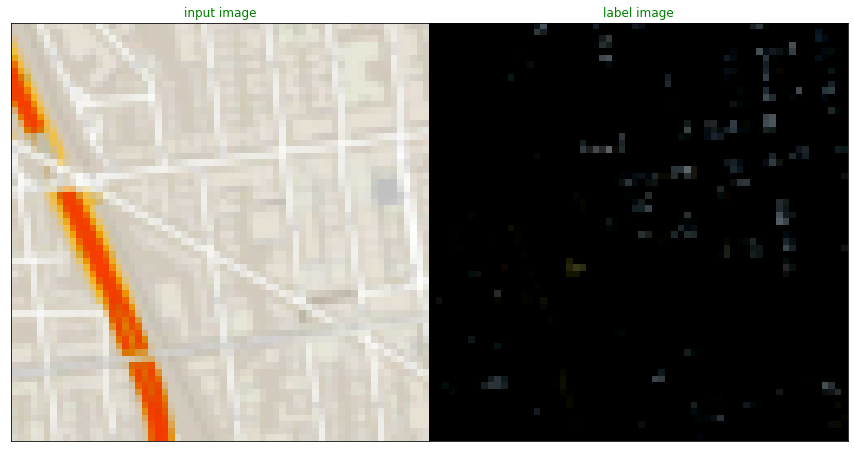

In [4]:
show_img_sample(train_ds.__getitem__(1)[0], train_ds.__getitem__(1)[1])

In [5]:
BATCH_SIZE = 16
device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch.manual_seed(0)
np.random.seed(0)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

## Model 
---

#### Generator
(batch, 3, 64, 64) -> (batch, 3, 64, 64)

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # Encoder reduce the spatial dimensions (width and height) while increasing the number of channels
        self.enc1 = self.conv2Relu(3, 32, 5)
        self.enc2 = self.conv2Relu(32, 64, pool_size=4)
        self.enc3 = self.conv2Relu(64, 128, pool_size=2)
        self.enc4 = self.conv2Relu(128, 256, pool_size=2)

        # Decoder perform the inverse operation of the encoder blocks, progressively increasing the spatial dimensions while decreasing the number of channels.
        self.dec1 = self.deconv2Relu(256, 128, pool_size=2)
        self.dec2 = self.deconv2Relu(128+128, 64, pool_size=2)
        self.dec3 = self.deconv2Relu(64+64, 32, pool_size=4)
        self.dec4 = nn.Sequential(
            nn.Conv2d(32+32, 3, 5, padding=2), 
            nn.Tanh()
        )

    def conv2Relu(self, in_c, out_c, kernel_size=3, pool_size=None):
        layer = []
        if pool_size:
            # Down width and height
            layer.append(nn.AvgPool2d(pool_size))
        # Up channel size
        layer.append(nn.Conv2d(in_c, out_c, kernel_size, padding=(kernel_size-1)//2))
        layer.append(nn.LeakyReLU(0.2, inplace=True))
        layer.append(nn.BatchNorm2d(out_c))
        layer.append(nn.ReLU(inplace=True))
        return nn.Sequential(*layer)

    def deconv2Relu(self, in_c, out_c, kernel_size=3, stride=1, pool_size=None):
        layer = []
        if pool_size:
            # Up width and height
            layer.append(nn.UpsamplingNearest2d(scale_factor=pool_size))
        # Down channel size
        layer.append(nn.Conv2d(in_c, out_c, kernel_size, stride, padding=1))
        layer.append(nn.BatchNorm2d(out_c))
        layer.append(nn.ReLU(inplace=True))
        return nn.Sequential(*layer)

    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.enc2(x1)
        x3 = self.enc3(x2)
        x4 = self.enc4(x3) # (b, 256, 4, 4)

        out = self.dec1(x4)
        out = self.dec2(torch.cat((out, x3), dim=1)) # concat channel 
        out = self.dec3(torch.cat((out, x2), dim=1))
        out = self.dec4(torch.cat((out, x1), dim=1)) # (b, 3, 64, 64)
        return out 

#### Discriminator
(batch, 3, 64, 64) *2 -> (batch, 1, 2, 2)

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.layer1 = self.conv2relu(6, 16, 5, cnt=1)
        self.layer2 = self.conv2relu(16, 32, pool_size=4)
        self.layer3 = self.conv2relu(32, 64, pool_size=2)
        self.layer4 = self.conv2relu(64, 128, pool_size=2)
        self.layer5 = self.conv2relu(128, 256, pool_size=2)
        self.layer6 = nn.Conv2d(256, 1, kernel_size=1)
        
    def conv2relu(self, in_c, out_c, kernel_size=3, pool_size=None, cnt=2):
        layer = []
        for i in range(cnt):
            if i == 0 and pool_size != None:
                # Down width and height 
                layer.append(nn.AvgPool2d(pool_size))
            # Down channel size 
            layer.append(nn.Conv2d(in_c if i == 0 else out_c, 
                                   out_c,
                                   kernel_size,
                                   padding=(kernel_size-1)//2))
            layer.append(nn.BatchNorm2d(out_c))
            layer.append(nn.LeakyReLU(0.2, inplace=True))
        return nn.Sequential(*layer)
        
    def forward(self, x, x1):
        x = torch.cat((x, x1), dim=1)
        out = self.layer5(self.layer4(self.layer3(self.layer2(self.layer1(x)))))
        return self.layer6(out) # (b, 1, 2, 2)
        

### Train
---

In [8]:
def train_fn(train_dl, G, D, criterion_bce, criterion_mae, optimizer_g, optimizer_d):
    G.train()
    D.train()
    LAMBDA = 100.0
    total_loss_g, total_loss_d = [], []
    for i, (input_img, real_img) in enumerate(tqdm(train_dl)):
        input_img = input_img.to(device)
        real_img = real_img.to(device)
        
        real_label = torch.ones(input_img.size()[0], 1, 2, 2)
        fake_label = torch.zeros(input_img.size()[0], 1, 2, 2)
        # Generator 
        fake_img = G(input_img)
        fake_img_ = fake_img.detach() # commonly using 
        out_fake = D(fake_img, input_img)
        loss_g_bce = criterion_bce(out_fake, real_label) # binaryCrossEntropy
        loss_g_mae = criterion_mae(fake_img, real_img) # MSELoss
        loss_g = loss_g_bce + LAMBDA * loss_g_mae 
        total_loss_g.append(loss_g.item())
        
        optimizer_g.zero_grad()
        optimizer_d.zero_grad()
        loss_g.backward(retain_graph=True)
        optimizer_g.step()
        # Discriminator
        out_real = D(real_img, input_img)
        loss_d_real = criterion_bce(out_real, real_label)
        out_fake = D(fake_img_, input_img)
        loss_d_fake = criterion_bce(out_fake, fake_label)
        loss_d = loss_d_real + loss_d_fake 
        total_loss_d.append(loss_d.item())
        
        optimizer_g.zero_grad()
        optimizer_d.zero_grad()
        loss_d.backward()
        optimizer_d.step()
    return mean(total_loss_g), mean(total_loss_d), fake_img.detach().cpu() 


def saving_img(fake_img, e):
    os.makedirs("generated", exist_ok=True)
    save_image(fake_img, f"generated/fake{str(e)}.png", range=(-1.0, 1.0), normalize=True)
    
def saving_logs(result):
    with open("train.pkl", "wb") as f:
        pickle.dump([result], f)
        
def saving_model(D, G, e):
    os.makedirs("weight", exist_ok=True)
    torch.save(G.state_dict(), f"weight/G{str(e+1)}.pth")
    torch.save(D.state_dict(), f"weight/D{str(e+1)}.pth")
        
def show_losses(g, d):
    fig, axes = plt.subplots(1, 2, figsize=(14,6))
    ax = axes.ravel()
    ax[0].plot(np.arange(len(g)).tolist(), g)
    ax[0].set_title("Generator Loss")
    ax[1].plot(np.arange(len(d)).tolist(), d)
    ax[1].set_title("Discriminator Loss")
    plt.show()


def train_loop(train_dl, G, D, num_epoch, lr=0.0002, betas=(0.5, 0.999)):
    G.to(device)
    D.to(device)
    optimizer_g = torch.optim.Adam(G.parameters(), lr=lr, betas=betas)
    optimizer_d = torch.optim.Adam(D.parameters(), lr=lr, betas=betas)
    criterion_mae = nn.L1Loss()
    criterion_bce = nn.BCEWithLogitsLoss()
    total_loss_d, total_loss_g = [], []
    result = {}
    
    for e in range(num_epoch):
        loss_g, loss_d, fake_img = train_fn(train_dl, G, D, criterion_bce, criterion_mae, optimizer_g, optimizer_d)
        total_loss_d.append(loss_d)
        total_loss_g.append(loss_g)
        saving_img(fake_img, e+1)
        
        if e%10 == 0:
            saving_model(D, G, e)
    try:
        result["G"] = total_loss_d 
        result["D"] = total_loss_g 
        saving_logs(result)
        show_losses(total_loss_g, total_loss_d)
        saving_model(D, G, e)
        print("successfully save model")
    finally:
        return G, D 
    

100%|██████████| 68/68 [01:24<00:00,  1.25s/it]


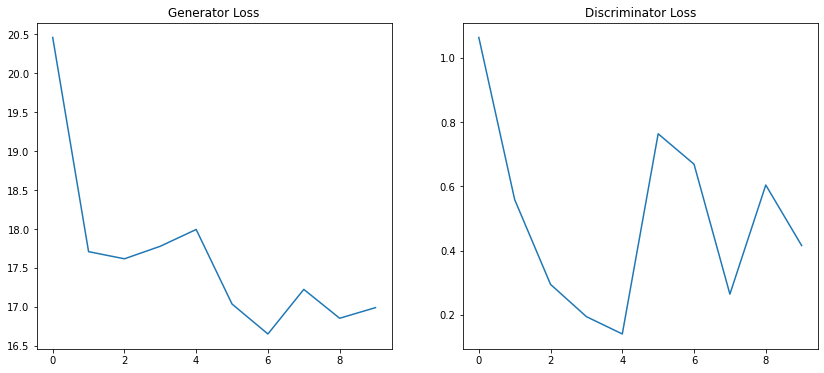

successfully save model


In [9]:
G = Generator()
D = Discriminator()
EPOCH = 10 
trained_G, trained_D = train_loop(train_dl, G, D, EPOCH)

### evaluate
---

In [10]:
def load_model(name):
    G = Generator()
    G.load_state_dict(torch.load(f"weight/G{name}.pth", map_location={"cuda:0": "cpu"}))
    G.eval()
    return G.to(device)

def train_show_img(name, G):
#     G = load_model(name)
    root = "generated"
    fig, axes = plt.subplots(int(name), 1, figsize=(12, 18))
    ax = axes.ravel()
    for i in range(int(name)):
        filename = os.path.join(root, f"fake{str(i+1)}.png")
        ax[i].imshow(Image.open(filename))
        ax[i].set_xticks([])
        ax[i].set_yticks([])

def de_norm(img):
    img_ = img.mul(torch.FloatTensor(STD).view(3, 1, 1))
    img_ = img_.add(torch.FloatTensor(MEAN).view(3, 1, 1)).detach().numpy()
    img_ = np.transpose(img_, (1, 2, 0))
    return img_ 

def evaluate(val_dl, name, G):
    with torch.no_grad():
        fig, axes = plt.subplots(6, 8, figsize=(12, 12))
        ax = axes.ravel()
#         G = load_model(name)
        for input_img, real_img in tqdm(val_dl):
            input_img = input_img.to(device)
            real_img = real_img.to(device)
            
            fake_img = G(input_img)
            batch_size = input_img.size()[0]
            batch_size_2 = batch_size * 2 
            
            for i in range(batch_size):
                ax[i].imshow(input_img[i].permute(1, 2, 0))
                ax[i+batch_size].imshow(de_norm(real_img[i]))
                ax[i+batch_size_2].imshow(de_norm(fake_img[i]))
                ax[i].set_xticks([])
                ax[i].set_yticks([])
                ax[i+batch_size].set_xticks([])
                ax[i+batch_size].set_yticks([])
                ax[i+batch_size_2].set_xticks([])
                ax[i+batch_size_2].set_yticks([])
                if i == 0:
                    ax[i].set_ylabel("Input Image", c="g")
                    ax[i+batch_size].set_ylabel("Real Image", c="g")
                    ax[i+batch_size_2].set_ylabel("Generated Image", c="r")
            plt.subplots_adjust(wspace=0, hspace=0)
            break   

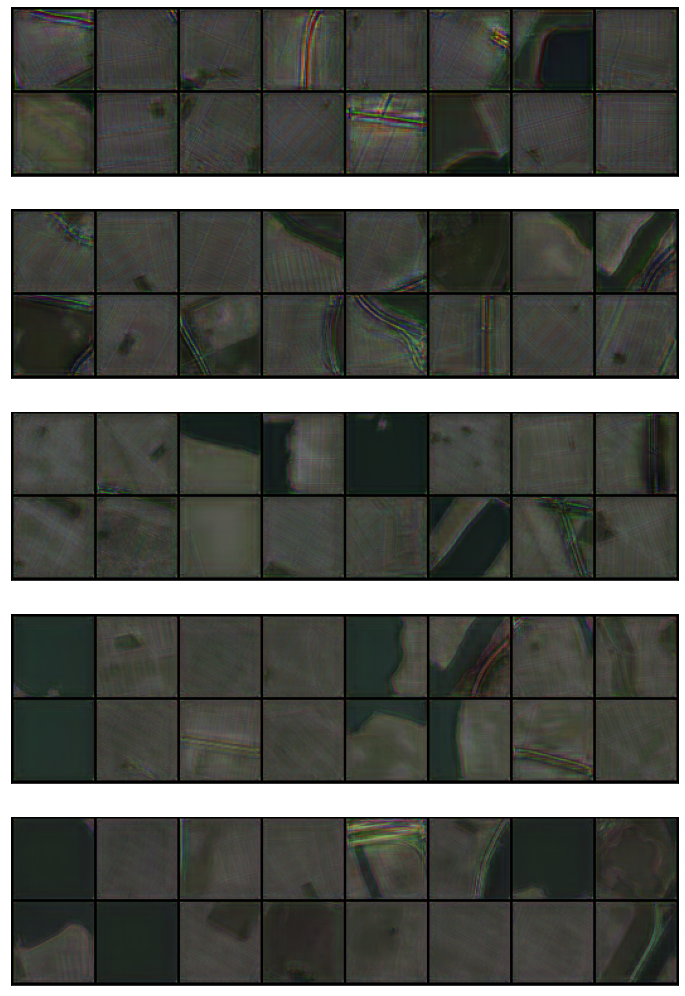

In [11]:
train_show_img(5, trained_G)

  0%|          | 0/69 [00:00<?, ?it/s]


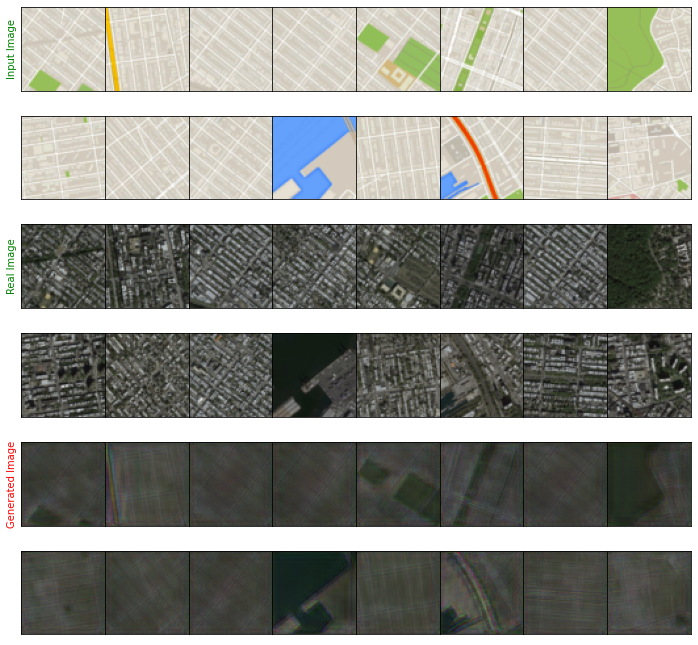

In [12]:
evaluate(val_dl, 5, trained_G)